In [1]:
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

cudnn.benchmark = True
plt.ion()

In [2]:
HOME = os.path.expanduser('~')
NEWS_DATA_DIR = "Projects/Datasets/public_news_set"
IMAGE_DATA_DIR = "Projects/Datasets/public_image_set"
TRAIN_FILE = "multimodal_train_cleaned_sample.tsv"
TEST_FILE = "multimodal_test_cleaned_sample.tsv"
VALID_FLIE = "multimodal_valid_cleaned_sample.tsv"
DATADIRS = [TRAIN_FILE, TEST_FILE, VALID_FLIE]
SUFFIX = '.jpg'

LABEL2ID = {0: "True", 1: "Satire/Parody", 2: "Misleading Content", 3: "Imposter", 4: "False connection", 5: "Manipulated Content"}
LABELS = [LABEL2ID[i] for i in range(6)]
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
mid_train = pd.read_csv(os.path.join(HOME, NEWS_DATA_DIR, TRAIN_FILE), sep='\t')
mid_test = pd.read_csv(os.path.join(HOME, NEWS_DATA_DIR, TEST_FILE), sep='\t')
mid_valid = pd.read_csv(os.path.join(HOME, NEWS_DATA_DIR, VALID_FLIE), sep='\t')
mid_train.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,jnoble50,red skull,1.553267e+09,NaN,True,ej4e1lj,https://i.imgur.com/eD7QGRM.jpg,b44rhx,NaN,58,psbattle_artwork,Red Skull,NaN,0,2,4
1,Gtash,cafe in bangkok with the cutest employees ever...,1.559911e+09,nynno.com,True,bxu2dd,https://external-preview.redd.it/MS7vkNibB3Yq1...,NaN,0.0,34,upliftingnews,Cafe in Bangkok With the Cutest Employees Ever...,0.78,1,0,0
2,RoyalPrinceSoldier,he betrayed him,1.400820e+09,NaN,True,chp14h4,http://i.imgur.com/9Q9CCDn.jpg,269qyi,NaN,8,psbattle_artwork,He betrayed him!,NaN,0,2,4
3,penguinseed,alderman wants to know exactly what bong shops...,1.403114e+09,dnainfo.com,True,28h8p1,https://external-preview.redd.it/lwbRUIzyGF5sU...,NaN,2.0,3,nottheonion,Alderman Wants to Know Exactly What 'Bong Shop...,0.71,1,0,0
4,DM90,man accused of stalking scots police officer s...,1.383750e+09,dailyrecord.co.uk,True,1q10us,https://external-preview.redd.it/_fNXvGtKcKn_U...,NaN,2.0,23,nottheonion,Man accused of stalking Scots police officer s...,0.84,1,0,0


In [4]:
im = Image.open(os.path.join(HOME, IMAGE_DATA_DIR, mid_train.id[3] + SUFFIX))
np.asarray(im).shape

(214, 320, 3)

In [5]:
# check the error image count
min_w = float("inf") 
min_h = float("inf")
max_w = 0
max_h = 0
e_count = 0
for i in range(len(mid_test)):    
    im = Image.open(os.path.join(HOME, IMAGE_DATA_DIR, mid_test.id[i] + ".jpg"))
    if im.size[0] > max_h:
        max_h = im.size[0]
    if im.size[1] > max_w:
        max_w = im.size[1]
    if im.size[0] < min_h:
        min_h = im.size[0]
    if im.size[1] < min_w:
        min_w = im.size[1]

min_w, min_h, max_w, max_h, e_count

(29, 108, 6396, 8400, 0)

## resize image to fit model need

In [6]:
import transformers

# transform the train data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# transform the test and validate data
transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
def load_trans(filepath, train=True):
    im = Image.open(filepath)
    # print(np.asarray(im).shape)
    # print(filepath)
    if im.mode != "RGB":
        im = im.convert(mode="RGB")
    im_trans = transform_train(im) if train else transform_val(im)
    return im_trans

In [8]:
class ImgDataset(Dataset):
    def __init__(self, df, train=True) -> None:
        super().__init__()
        self.df = df
        self.train = train
        df.dtype = np.float64
        self.labels = df['6_way_label'].values
        self.ids = df['id'].values

    def __getitem__(self, idx):
        img_path = os.path.join(HOME, IMAGE_DATA_DIR, self.df.id[idx] + SUFFIX)
        img_tensor = load_trans(img_path, self.train)
        label = self.labels[idx]
        return img_tensor, label

    def __len__(self):
        return len(self.labels)


In [16]:
mid_train_dataset = ImgDataset(mid_train)
train_dataloader = DataLoader(mid_train_dataset, batch_size=32)
mid_test_dataset = ImgDataset(mid_test, train=False)
test_dataloader = DataLoader(mid_test_dataset, batch_size=32)
mid_valid_dataset = ImgDataset(mid_valid, train=False)
valid_dataloader = DataLoader(mid_valid_dataset, batch_size=32)

dataloaders = {'train': train_dataloader, 'val': valid_dataloader}
dataset_sizes = {'train': len(mid_train_dataset), 'val': len(mid_valid_dataset)}

In [10]:
im = Image.open('/home/yangu/Projects/Datasets/public_image_set/ctdk4x3.jpg')
# im.convert(mode='RGB')

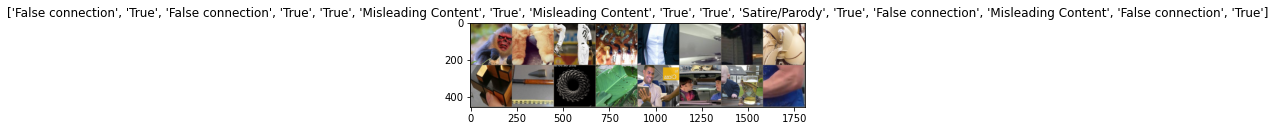

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[LABEL2ID[x] for x in classes.tolist()])

In [12]:
# fine-tune model
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 6)
num_ftrs

model_ft = model_ft.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [13]:
# train model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], total=len(dataloaders[phase])):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {LABEL2ID[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


 31%|███       | 1053/3411 [08:50<18:59,  2.07it/s]

In [46]:
# test read file from zip file
import io
import tarfile

tar = tarfile.open('/home/yangu/Downloads/public_images.tar.bz2', 'r:bz2')
t = tar.getmember('public_image_set/chu0hgb.jpg')
te = tar.extractfile(t).read()
Image.open(io.BytesIO(te))